In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [223]:
import MeCab

m = MeCab.Tagger()

out = m.parse("너 오늘 왜 이렇게 예민해?")

print(out)

너	NP,*,F,너,*,*,*,*
오늘	MAG,성분부사|시간부사,T,오늘,*,*,*,*
왜	MAG,문장부사|양상부사,F,왜,*,*,*,*
이렇게	MAG,*,F,이렇게,*,*,*,*
예민	XR,*,T,예민,*,*,*,*
해	XSA+EF,*,F,해,Inflect,XSA,EF,하/XSA/*+아/EF/*
?	SF,*,*,*,*,*,*,*
EOS



In [224]:
## 파일 로드
path = '~/aiffel/dktc/data_forder/train.csv'
data = pd.read_csv(path)

In [225]:
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [226]:
print('데이터 개수 :',len(data),'\n')
print('Null 개수 :',data.isnull().sum())

데이터 개수 : 3950 

Null 개수 : idx             0
class           0
conversation    0
dtype: int64


In [227]:
import MeCab
import pandas as pd
import re

# MeCab 형태소 분석기 초기화
mecab = MeCab.Tagger()

# MeCab의 parse 결과를 파싱하여 (word, pos) 튜플의 리스트로 변환하는 함수
def parse_mecab_output(text):
    parsed = mecab.parse(text)
    parsed_lines = parsed.strip().split('\n')
    tokens = []
    for line in parsed_lines:
        if line == 'EOS':
            break
        else:
            # MeCab의 출력은 "표면형\t품사 정보" 형식입니다.
            try:
                surface, feature = line.split('\t')
                # 품사 정보는 ','로 구분되어 있습니다.
                pos = feature.split(',')[0]
                tokens.append((surface, pos))
            except ValueError:
                continue  # 빈 줄이나 형식에 맞지 않는 줄은 무시
    return tokens

# 전처리 및 형태소 분석 클래스 정의
class TextPreprocessor:
    def __init__(self, pos_to_keep=None):
        # 유지할 품사 설정
        if pos_to_keep is None:
            # 주요 품사 리스트 (명사, 동사, 형용사 등)
             self.pos_to_keep = [
                'NNG',  # 일반 명사
                'NNP',  # 고유 명사
                'NNB',  # 의존 명사
                'NNBC', # 단위를 나타내는 명사
                'NR',   # 수사
                'NP',   # 대명사
                'VV',   # 동사
                'VA',   # 형용사
                'VX',   # 보조 용언
                'VCP',  # 긍정 지정사 ('이다')
                'VCN',  # 부정 지정사 ('아니다')
                'MM',   # 관형사
                'MAG',  # 일반 부사
                'MAJ',  # 접속 부사
                'XR',   # 어근
                'IC',   # 감탄사
                'JKS',  # 주격 조사
                'JKC',  # 보격 조사
                'JKG',  # 관형격 조사
                'JKO',  # 목적격 조사
                'JKB',  # 부사격 조사
                'JKV',  # 호격 조사
                'JKQ',  # 인용격 조사
                'JX',   # 보조사
                'JC',   # 접속 조사
                'EP',   # 선어말 어미
                'EF',   # 종결 어미
                'EC',   # 연결 어미
                'ETN',  # 명사형 전성 어미
                'ETM',  # 관형형 전성 어미
                'XPN',  # 체언 접두사
                'XSN',  # 명사 파생 접미사
                'XSV',  # 동사 파생 접미사
                'XSA',  # 형용사 파생 접미사
                'SN',   # 숫자
                'SL',   # 외국어
                'SH',   # 한자
                'SY',   # 기호
            ]
        else:
            self.pos_to_keep = pos_to_keep

    # 텍스트 정규화 함수
    def normalize_text(self, text):
        
        # 반복되는 문자 줄이기 (e.g., ㅋㅋㅋㅋ -> ㅋㅋ)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        # 다중 공백 제거
        text = re.sub(r'\s+', ' ', text)
        # 앞뒤 공백 제거
        text = text.strip()
        return text

    # 문장을 형태소 분석하고 필요한 품사만 추출하는 함수
    def filter_by_pos(self, sentence):
        parsed_sentence = parse_mecab_output(sentence)
        # 필요한 품사만 추출
        filtered_tokens = [word for word, pos in parsed_sentence if pos in self.pos_to_keep]
        return filtered_tokens

    # 전처리 및 토큰화 함수
    def preprocess_and_tokenize(self, sentence):
        if pd.isnull(sentence):
            return []
        # 텍스트 정규화
        sentence = self.normalize_text(sentence)
        # 형태소 분석 수행 및 필요한 품사만 추출
        tokens = self.filter_by_pos(sentence)
        return tokens

    # 데이터프레임에 전처리 및 토큰화 적용
    def apply_to_dataframe(self, df,column_name):
        df[column_name] = df['conversation'].apply(self.preprocess_and_tokenize)
        return df

In [228]:
# 품사 필터링을 적용하여 전처리 객체 생성
preprocessor = TextPreprocessor()

# 데이터프레임 로드 (df로 복사하여 진행)
df = data.copy()

# 전처리 및 토큰화 적용
df = preprocessor.apply_to_dataframe(df,'preprocess_conversation')

# 결과 확인
df.tail()

,idx,class,conversation,preprocess_conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,"[준, 하, 야, 대가리, 가, 왜, 이렇게, 크, 냐, 머리, 가, 뭐, 밥, 먹..."
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,"[내, 가, 지금, 너, 아들, 김길준, 데리, 고, 있, 어, 살리, 고, 싶, ..."
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,"[나, 는, 씨, 같, 은, 사람, 보, 면, 참, 신기, 하, 더라, 어떻게, 저..."
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,"[누구, 맘대로, 여기, 서, 장사, 하, 래, 무슨, 일, 남, 의, 구역, 에서..."
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...,"[희정, 씨, 네, 주말, 에, 시간, 이, 넘쳐나, 나, 갑자기, 왜, 그러, 손..."


In [229]:
# 레이블 인코딩
label_mapping = {
    '협박 대화': 0,
    '기타 괴롭힘 대화': 1,
    '갈취 대화': 2,
    '직장 내 괴롭힘 대화': 3
}
df['class'] = df['class'].map(label_mapping)


In [230]:
# 토크나이저 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['preprocess_conversation'])

# 시퀀스 인코딩
sequences = tokenizer.texts_to_sequences(df['preprocess_conversation'])

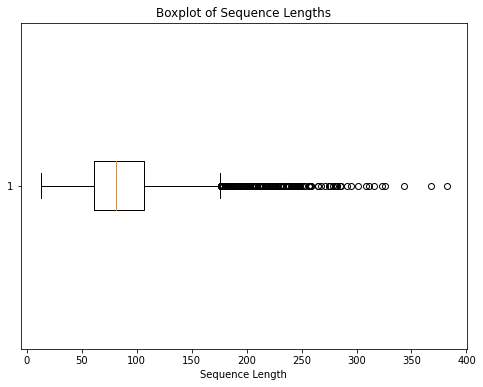

In [231]:
sequence_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 6))
plt.boxplot(sequence_lengths, vert=False)
plt.title('Boxplot of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

In [232]:
# 최대 시퀀스 길이 결정 (% 로 결정)
max_seq_len = int(np.percentile([len(seq) for seq in sequences], 99)) 

In [233]:
# 패딩 적용
X = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

# 레이블 준비
y = df['class'].values

In [234]:
# 데이터프레임에서 클래스별로 200개씩 랜덤 샘플링하여 검증 데이터 생성
df_val = df.groupby('class', group_keys=False).apply(lambda x: x.sample(200, random_state=42))

# 나머지 데이터를 학습 데이터로 사용
df_train = df.drop(df_val.index)

# 인덱스 추출
train_indices = df_train.index
val_indices = df_val.index

# 학습 및 검증 데이터 생성
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

# 03. 모델 구조 (transformer encoder = Base model)

In [235]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [236]:
# 패딩 마스크 생성 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [237]:
def scaled_dot_product_attention(q, k, v, mask):
    """ 스케일드 닷 프로덕트 어텐션 """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Q와 K의 행렬 곱

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스크가 주어졌을 경우 -inf 적용
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax를 통해 attention weights 계산
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # attention weights와 V의 행렬곱
    output = tf.matmul(attention_weights, v)

    return output

In [238]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 가중치 행렬 정의
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """ 헤드 분할: [batch_size, seq_len, d_model] -> [batch_size, num_heads, seq_len, depth] """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # 선형 변환
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # 헤드 분할
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention = scaled_dot_product_attention(q, k, v, mask)

        # 헤드 병합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 선형 변환
        output = self.dense(concat_attention)

        return output

    def get_config(self):
        # 직렬화 지원을 위한 설정 저장
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [239]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout_rate, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티 헤드 어텐션
    attention = MultiHeadAttention(d_model, num_heads)(inputs, inputs, inputs, padding_mask)
    attention = tf.keras.layers.Dropout(dropout_rate)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 네트워크
    outputs = tf.keras.layers.Dense(units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)
    outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [240]:
# 인코더 전체
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout_rate,
            maximum_position_encoding,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 및 포지셔널 인코딩
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(maximum_position_encoding, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    # 인코더 레이어 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout_rate=dropout_rate,
                                name=f"encoder_layer_{i}",
                                )(inputs=[outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 04. 모델 구조 (transformer encoder = Base model)

In [241]:
# 인코더 모델 생성
def build_encoder_model():
    inputs = tf.keras.Input(shape=(max_seq_len,), name="inputs")
    padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='padding_mask')(inputs)

    # 인코더 출력
    encoder_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate,
        maximum_position_encoding=max_seq_len,
        name="encoder"
    )(inputs=[inputs, padding_mask])

    # 글로벌 평균 풀링
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(encoder_outputs)

    # 출력 레이어 (다중 분류)
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='outputs')(pooled_output)

    # 모델 정의
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_classifier")

    return model

In [242]:
# 하이퍼파라미터 설정
vocab_size = len(tokenizer.word_index) + 1
num_layers = 2
d_model = 128
num_heads = 4
units = 1024
dropout_rate = 0.4
num_classes = 4  # 클래스 수

In [243]:
# 모델 생성
model = build_encoder_model()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "transformer_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 246)]        0                                            
__________________________________________________________________________________________________
padding_mask (Lambda)           (None, 1, 1, 246)    0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    1885056     inputs[0][0]                     
                                                                 padding_mask[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_8 (Glo (None, 128)          0           encoder[0][0

# 05. 모델 학습 (transformer encoder = Base model)

In [244]:
# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# 모델 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
99/99 [==============================] - 7s 38ms/step - loss: 1.4723 - accuracy: 0.3537 - val_loss: 0.8201 - val_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 0.82015, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 2/20
99/99 [==============================] - 3s 35ms/step - loss: 0.5345 - accuracy: 0.8076 - val_loss: 0.6112 - val_accuracy: 0.8062

Epoch 00002: val_loss improved from 0.82015 to 0.61123, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 3/20
99/99 [==============================] - 3s 34ms/step - loss: 0.2714 - accuracy: 0.9137 - val_loss: 0.4650 - val_accuracy: 0.8662

Epoch 00003: val_loss improved from 0.61123 to 0.46505, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 4/20
99/99 [==============================] - 3s 35ms/step - loss: 0.1491 - accuracy: 0.9483 - val_loss: 0.6371 - val_accuracy: 0.8487

Epoch 00004: val_loss did not improve from 0.46505
Epoch 5/20
99/99 [==============================] - 3s 34ms/step - loss: 0.0653 - accuracy: 0.9790 - val_loss: 0.7530 - val_accuracy: 0.8475

Epoch 00005: val_loss did not improve from 0.46505
Epoch 6/20
99/99 [==============================] - 3s 34ms/step - loss: 0.0525 - accuracy: 0.9832 - val_loss: 0.7488 - val_accuracy: 0.8575

Epoch 00006: val_loss did not improve from 0.46505
Epoch 7/20
99/99 [==============================] - 3s 34ms/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.9741 - val_accuracy: 0.8462

Epoch 00007: val_loss did not improve from 0.46505
Epoch 8/20
99/99 [==============================] - 3s 34ms/step - loss: 0.0260 - accuracy: 0.9902 - val_loss: 1.0300 - val_accuracy: 0.8288

Epoch 00008: val_loss did not improve from 0.46505
Epoch 9/20
99/99 [=================

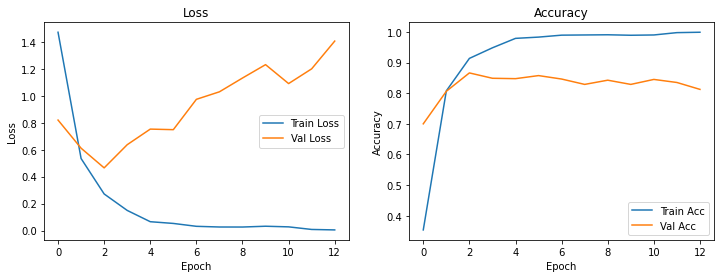

In [245]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [246]:
from sklearn.metrics import classification_report
from keras.models import load_model

# PositionalEncoding 클래스를 포함한 custom_objects 정의
custom_objects = {
    'MultiHeadAttention': MultiHeadAttention,
    'PositionalEncoding': PositionalEncoding
}

# SavedModel 형식으로 저장된 모델 불러오기
best_model = load_model('best_model', custom_objects=custom_objects)

# 검증 데이터에 대한 예측
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# 분류 보고서를 딕셔너리 형태로 얻기
report_dict = classification_report(y_val, y_pred_classes, target_names=label_mapping.keys(), output_dict=True)

# 딕셔너리를 DataFrame으로 변환
report_df = pd.DataFrame(report_dict).transpose()

# 필요한 컬럼만 선택하고 순서 지정
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]

# 소수점 자릿수 설정
report_df = report_df.round(4)

# 결과 확인
report_df

,precision,recall,f1-score,support
협박 대화,0.7876,0.8900,0.8357,200.0000
기타 괴롭힘 대화,0.8827,0.7900,0.8338,200.0000
갈취 대화,0.8593,0.8550,0.8571,200.0000
직장 내 괴롭힘 대화,0.9490,0.9300,0.9394,200.0000
accuracy,0.8662,0.8662,0.8662,0.8662
macro avg,0.8696,0.8662,0.8665,800.0000
weighted avg,0.8696,0.8662,0.8665,800.0000
